## Reinforcement Learning

Reinforcement learning involves training agents - programs, robots, etc - such that they learn how to behave in a particular environment. Reinforcement learning agents learn by interacting with their environment and seeing what happens as a result of their actions. This is a really exciting area of artificial intelligence - here's where we get to design agents that are autonomous in both their learning and their behavior.

The basic structure of a reinforcement learning problem is:

- we model the world as various **states** the agent can be in.
- the agent can take **actions** that move between these states.
- each state has an associated **reward** (which may be negative, i.e. a "punishment").
- the agent **explores** these states and learns which sequence of actions tend to lead to more rewards.
- the agent uses what it has learned to behave in a way that maximizes reward (it **exploits** to the best of its knowledge).

There are many different ways a reinforcement learning agent can be trained, but a common one is called _Q-learning_. The agent learns a function called $Q(s,a)$ which takes a state $s$ and an action $a$ and returns a value for it. This value is the _expected reward_, cumulative from this point onwards (though agents may value future rewards less than present rewards). In effect, the higher the value, the more the agent believes $a$ is a good action to take in state $s$.

The way the agent actually behaves (i.e. decides what to do) is governed by what is called a _policy_. With Q-learning a common policy is a _greedy policy_ which just means take the highest valued action given by $Q(s,a)$.

There are two problems in reinforcement learning that you should be familiar with:

- the _credit assignment_ problem: sometimes a reward may be due to an action taken a long time ago - how do we properly assign credit to that action? Generally we can propagate rewards backwards through time, so an early action that later leads to a reward will have some of that reward assigned to it. This will be clearer when we dig into the code.
- the _exploration vs exploitation_ problem: does the agent stick with certain rewards at the expense of possibly missing out on greater but unknown rewards (exploit)? Does the agent explore more states to find these possibly greater rewards, but at the risk of lower or negative ones (explore)? A simple approach, which we'll use here, is to set some value, called epsilon ($\epsilon$), which can be from 0 to 1. With this $\epsilon$ probability the agent will take a random action instead of the best one. This variation of the greed policy is called the $\epsilon$-greedy policy.

In this guide we'll put together a very simple Q-learning agent that navigates a grid world. Grid worlds consist of some hazards (which lead to negative reward) and some kind of "treasure" which yields positive reward. The agent then must learn how to efficiently navigate towards the treasure while avoiding the hazards.

For simplicity, we are going to consider a _fully-observed_ scenario; that is, when an agent takes an action, they see all the results of it (this is contrasted to _partially-observable_ scenarios, where some results remain unknown, perhaps until later or surfacing in different ways). Our scenario will also be _deterministic_ in that an action, from a given state, always leads to the same outcome.

## The environment

A reinforcement learning agent needs an environment to explore and interact with, so let's create that first. While the [OpenAI Gym](https://gym.openai.com/) provides a lot of environments to get started with, I think seeing how an environment is defined makes understanding easier.

For this problem we'll think in terms of _episodes_ - we place the agent somewhere in the grid, it moves around until it reaches a _terminal_ state (i.e. a position that ends the episode), which may give negative reward or a positive reward.

Our grid will consist of empty spaces (valued at 0), holes (which are terminal states that give a reward of -1) and positive reward spaces (which are also terminal states). Our agent will start in a random non-terminal state and ideally learns how to find the highest value reward.

We're going to tweak things a little bit and make it so that every step the agent takes also gives -1 reward. This prevents the agent from wandering around aimlessly, instead encouraging to find the shortest path to a satisfactory reward. I say "satisfactory" because the agent no longer is looking for the maximum reward available - if the maximum reward is 5, but it's 10 steps away, the agent will ultimately end the episode with a total reward of -5. But perhaps there's a reward tile one step away that has a reward of only 2 - the "smart" thing to do is to go for the closer, lesser reward, because the agent will end the episode with a total reward of +1. Our agent, if trained enough, will learn exactly these kinds of behaviors.

We'll design it so that we can pass in a grid (i.e. a list of lists) that is filled with reward values. Values of `None` specify a hole in the world.

For a grid world, the states are just `(x,y)` coordinate positions.

The environment will also tell us what valid actions are given a state. For example, if the agent is in the upper-left corner of the map, the only valid actions are `right`, and `down`.

In [1]:
class Environment():
    def __init__(self, grid):
        self.grid = grid
        self.n_rows = len(grid)
        self.n_cols = len(grid[0])
        self.positions = self._positions()
        self.starting_positions = [p for p in self.positions
                                   if not self.is_terminal_state(p)]

    def actions(self, pos):
        """possible actions for a state (position)"""
        r, c = pos
        actions = []
        if r > 0:
            actions.append('up')
        if r < self.n_rows - 1:
            actions.append('down')
        if c > 0:
            actions.append('left')
        if c < self.n_cols - 1:
            actions.append('right')
        return actions

    def value(self, pos):
        """retrieve the reward value for a position"""
        r, c = pos
        return self.grid[r][c]

    def _positions(self):
        """all positions"""
        positions = []
        for r, row in enumerate(self.grid):
            for c, _ in enumerate(row):
                positions.append((r,c))
        return positions

    def is_terminal_state(self, state):
        """tell us if the state ends the game"""
        val = self.value(state)
        return val is None or val > 0

    def reward(self, state):
        """the reward of a state:
        -1 if it's a hole,
        -1 if it's an empty space (to penalize each move),
        otherwise, the value of the state"""
        val = self.value(state)
        if val is None or val == 0:
            return -1
        return val

We can now use this `Environment` class to define a grid world like so:

In [2]:
env = Environment([
    [   0,  0,    0,  0,    0, None, None],
    [   0,  0,    5,  0,    0,    0, None],
    [   0,  0, None,  5, None,    0, None],
    [None,  0,    5,  5, None,   10,    0]
])

## The agent

Now we'll move on to designing the agent.

A few notes here:

- We have a `learning_rate` parameter here (it takes a value from 0 to 1). This is useful for stochastic (non-deterministic) environments; it allows you to control how much new information overwrites existing information about the environment. In stochastic environments, sometimes random weird things happen and you don't want it influencing the agent too much. In deterministic environment (like ours), this isn't a problem, so you want to set it to 1 so the agent learns as quickly as possible.
- The `discount` value (from 0 to 1) specifies how much future rewards are discounted by. For instance, with `discount=0.5`, a reward at the next time step is only worth half as much as it would be now. A reward at the time step after that would be discounted twice-over, i.e. it would be worth only `0.5 * 0.5` of it's actual value.
- Instead of implementing Q as a function, we're using a lookup table (i.e. a dictionary). This works fine for our purposes here, but just know that it can also be a learned function (this is where deep-Q learning comes in, which I'll cover in another guide). When the number of possible states gets really large (like with the game of Go) this lookup table approach becomes infeasible - there's just not enough memory to keep track of everything.

The most important piece here is the `_learn` method. There you can see how these individual parts come together to update the value of an `(state, action)` pair. Note that when we propagate values from future states we are optimistic and take the maximum of those values. This is appropriate because we are using a greedy policy - we'll always choose the action that takes us to the best state, so we'll always be getting the next maximum (known) reward value.

In [3]:
class QLearner():
    def __init__(self, state, environment, rewards, discount=0.5, explore=0.5, learning_rate=1):
        """
        - state: the agent's starting state
        - rewards: a reward function, taking a state as input, or a mapping of states to a reward value
        - discount: how much the agent values future rewards over immediate rewards
        - explore: with what probability the agent "explores", i.e. chooses a random action
        - learning_rate: how quickly the agent learns. For deterministic environments (like ours), this should be left at 1
        """
        self.discount = discount
        self.explore = explore
        self.learning_rate = learning_rate
        self.R = rewards.get if isinstance(rewards, dict) else rewards

        # our state is just our position
        self.state = state
        self.reward = 0
        self.env = environment

        # initialize Q
        self.Q = {}

    def reset(self, state):
        self.state = state
        self.reward = 0

    def actions(self, state):
        return self.env.actions(state)

    def _take_action(self, state, action):
        r, c = state
        if action == 'up':
            r -= 1
        elif action == 'down':
            r += 1
        elif action == 'right':
            c += 1
        elif action == 'left':
            c -= 1

        # return new state
        return (r,c)

    def step(self, action=None):
        """take an action"""
        # check possible actions given state
        actions = self.actions(self.state)

        # if this is the first time in this state,
        # initialize possible actions
        if self.state not in self.Q:
            self.Q[self.state] = {a: 0 for a in actions}

        if action is None:
            if random.random() < self.explore:
                action = random.choice(actions)
            else:
                action = self._best_action(self.state)
        elif action not in actions:
            raise ValueError('unrecognized action!')

        # remember this state and action
        # so we can later remember
        # "from this state, taking this action is this valuable"
        prev_state = self.state

        # update state
        self.state = self._take_action(self.state, action)

        # update the previous state/action based on what we've learned
        self._learn(prev_state, action, self.state)
        return action

    def _best_action(self, state):
        """choose the best action given a state"""
        actions_rewards = list(self.Q[state].items())
        return max(actions_rewards, key=lambda x: x[1])[0]

    def _learn(self, prev_state, action, new_state):
        """update Q-value for the last taken action"""
        if new_state not in self.Q:
            self.Q[new_state] = {a: 0 for a in self.actions(new_state)}
        reward = self.R(new_state)
        self.reward += reward
        self.Q[prev_state][action] = self.Q[prev_state][action] + self.learning_rate * (reward + self.discount * max(self.Q[new_state].values()) - self.Q[prev_state][action])

With the agent defined, we can try running it in our environment:

In [4]:
import time
import random

# try discount=0.1 and discount=0.9
pos = random.choice(env.starting_positions)
agent = QLearner(pos, env, env.reward, discount=0.9, learning_rate=1)

print('before training...')
agent.explore = 0
for i in range(10):
    game_over = False
    # start at a random position
    pos = random.choice(env.starting_positions)
    agent.reset(pos)
    while not game_over:
        agent.step()
        game_over = env.is_terminal_state(agent.state)
    print('reward:', agent.reward)

print('training...')
episodes = 500
agent.explore = 0.5
for i in range(episodes):
    #print('episode:', i)
    game_over = False
    steps = 0

    # start at a random position
    pos = random.choice(env.starting_positions)
    agent.reset(pos)
    while not game_over:
        agent.step()
        steps += 1
        game_over = env.is_terminal_state(agent.state)

# print out the agent's Q table
print('learned Q table:')
for pos, vals in agent.Q.items():
    print('{} -> {}'.format(pos, vals))

# let's see how it does
print('after training...')
agent.explore = 0
for i in range(10):
    # start at a random position
    pos = random.choice(env.starting_positions)
    agent.reset(pos)
    game_over = False
    while not game_over:
        agent.step()
        game_over = env.is_terminal_state(agent.state)
    print('reward:', agent.reward)

before training...
('reward:', 5)
('reward:', 2)
('reward:', -1)
('reward:', 10)
('reward:', -2)
('reward:', 5)
('reward:', 5)
('reward:', 5)
('reward:', 9)
('reward:', 2)
training...
learned Q table:
(1, 3) -> {'down': 5.0, 'right': 4.58, 'up': 2.15, 'left': 5.0}
(3, 0) -> {'right': 0, 'up': 0}
(2, 1) -> {'down': 3.5, 'right': -1.0, 'up': 3.5, 'left': 0.935}
(2, 6) -> {'down': 0, 'up': 0, 'left': 0}
(1, 6) -> {'down': 0, 'up': 0, 'left': 0}
(2, 5) -> {'down': 10.0, 'right': -1.0, 'up': 6.2, 'left': -1.0}
(0, 3) -> {'down': 3.5, 'right': 3.122, 'left': 3.5}
(1, 2) -> {'down': 0, 'right': 0, 'up': 0, 'left': 0}
(1, 5) -> {'down': 8.0, 'right': -1.0, 'up': -1.0, 'left': 4.58}
(3, 6) -> {'up': -1.0, 'left': 10.0}
(2, 2) -> {'down': 0, 'right': 0, 'up': 0, 'left': 0}
(1, 1) -> {'down': 2.15, 'right': 5.0, 'up': 2.15, 'left': 2.15}
(3, 2) -> {'right': 0, 'up': 0, 'left': 0}
(0, 0) -> {'down': 2.15, 'right': 2.15}
(0, 4) -> {'down': 4.58, 'right': -1.0, 'left': 2.15}
(1, 4) -> {'down': -1.0,

Here we're training the agent for 500 episodes, which should be enough for it to thoroughly explore the space. If you don't train an agent enough it may fail to learn optimal behaviors - it hasn't experienced enough yet.

The Q lookup table the agent has learned is a bit hard to parse. Let's visualize the policy it's learned - we'll render out the grid world and label each non-terminal tile with the agent's preferred action for that tile.

(The following `Renderer` code is not important to understanding Q-learning, it's just so we can render the grid)

In [5]:
import math
import textwrap
from PIL import Image, ImageDraw, ImageFont

font = ImageFont.load_default()


class Renderer():
    """renders a grid with values (for the gridworld)"""
    def __init__(self, grid, cell_size=60):
        self.grid = grid
        self.cell_size = cell_size

        grid_h = len(grid)
        grid_w = max(len(row) for row in grid)
        self.size = (grid_w * self.cell_size, grid_h * self.cell_size)

    def _draw_cell(self, x, y, fill, color, value, pos, text_padding=10):
        self.draw.rectangle([(x, y), (x+self.cell_size, y+self.cell_size)], fill=fill)

        # render text
        y_mid = math.floor(self.cell_size/2)
        lines = textwrap.wrap(str(value), width=15)
        _, line_height = self.draw.textsize(lines[0], font=font)
        height = len(lines) * line_height + (len(lines) - 1) * text_padding
        current_height = y_mid - height/2

        for line in lines:
            w, h = self.draw.textsize(line, font=font)
            self.draw.text((x + (self.cell_size - w)/2, y + current_height), line, font=font, fill=color)
            current_height += h + text_padding

    def render(self, pos=None):
        """renders the grid,
        highlighting the specified position if there is one"""
        self.img = Image.new('RGBA', self.size, color=(255,255,255,0))
        self.draw = ImageDraw.Draw(self.img)

        for r, row in enumerate(self.grid):
            for c, val in enumerate(row):
                if val is None:
                    continue
                fill = (220,220,220,255) if (r + c) % 2 == 0 else (225,225,225,255)

                # current position
                if pos is not None and pos == (r, c):
                    fill = (255,255,150,255)
                self._draw_cell(c * self.cell_size, r * self.cell_size, fill, (0,0,0,255), val, (r,c))

        return self.img

learned policy


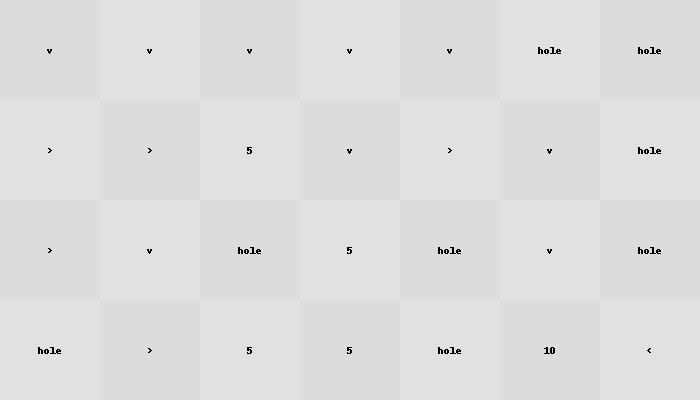

In [6]:
import IPython.display as IPdisplay

move_to_arrow = {
    'right': '>',
    'left': '<',
    'up': '^',
    'down': 'v'
}

def cell_label(qvals, reward, show_qvals=True):
    # given the Q values for a state and the state's reward,
    # output a string describing it
    n = []
    if not all(v == 0 for v in qvals.values()):
        if show_qvals:
            for k, v in qvals.items():
                n.append('{}{:.2f}'.format(k[0].upper(), v))
        best_move = max(qvals.keys(), key=lambda k: qvals[k])
        n.append(move_to_arrow[best_move])
    else:
        n.append(str(reward) if reward is not None else 'hole')
    return '\n'.join(n)


# generate the grid, with labels, to render
grid = []
for i, row in enumerate(env.grid):
    grid.append([
        cell_label(
                agent.Q.get((i,j), {}),
                env.value((i,j)),
                show_qvals=False) for j, col in enumerate(row)])


# display
print('learned policy')
renderer = Renderer(grid, cell_size=100)
renderer.render().save('/tmp/gridworld.png')
IPdisplay.Image(filename='/tmp/gridworld.png')

If you've trained your agent enough, the learned policy depicted here should look pretty reasonable. If the agent is within a few steps from the best reward, it will move towards that. If it's a little too far, it'll move towards the closer reward. And it should consistently be moving away from holes.

That's the basics of reinforcement learning (Q-learning in particular) - try changing up the grid world and re-training your agent!